In [71]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [245]:
log_files = [
"mc1-1.log",
"mc1-2.log",
"mc1-3.log",
"mc1-4.log",
"mc1-5.log",
"mc1-6.log",
"mc1-7.log",
"mc1-12.log",
"mc1-2_ondemand.log",
"mc1-7_performance.log"
]

runtime_files = [
"mc1-1-results.log",
"results-2.log",
"results-3.log",
"results-4.log",
"results-5.log",
"results-6.log",
"results-7.log",
"results-12.log"
]
runtime_ondemand = "results-2_ondemand.log"
log_ondemand = "mc1-2_ondemand.log"

runtime_performance = "results-7_performance.log"
log_performance = "mc1-7_performance.log"

# Map of which MC1 trained with which value of lambda:
lambda_list = [
    0.001,
    0.01,
    0.1,
    1.0,
    10.0,
    100.0,
    0.0001,
    0.00001,
    'ondemand',
    'performance'
]

In [259]:
'''
Return a dictionary list containing the workload name, 
iteration, runtime, lambda value, and/or governor type 
(RL, ondemand, performance, powersave) per dict
'''
def parse_runtimes(f, lambd, gov):
    global lambda_dict
    cols = ['name', 'iter', 'runtime', 'lambda', 'gov']
    with open(f, 'r') as results_file:
        dicts = []
        while not "\t" in results_file.readline():
            continue
        line = results_file.readline()
        while "*" not in line and line is not None:
            d = {}
            ln = line.strip().split("\t")
            d['workload'] = ln[0]
            d['iter'] = int(ln[4])
            d['runtime'] = float(ln[3])
            d['lambda'] = lambd
            d['start'] = float(ln[1])
            d['end'] = float(ln[2])
            d['gov']= gov
            dicts.append(d)
            line = results_file.readline()
        return dicts
'''
Return dataframe runs with relevant data for the given workloads, where 
each row in the dataframe runs is a specific run of a specific workload.

Metrics to be returned for each (workload, lambda, governor, iteration) 
scenario are:
1. Average (arithmetic and geometric) runtimes for each workload scenario
2. Energy used on average across runs for each workload scenario
3. [Number of instances (samples) * overage] of violations of THERM_LIMIT
'''
def combine_runtime_stats(runs, f_list, lambda_list):
    THERM_LIMIT = 50
    runs['thermal_overage'] = np.nan
    runs['max_temp'] = np.nan
    runs['min_temp'] = np.nan
    runs['energy'] = np.nan
    for log, lambd in zip(f_list, lambda_list):
        print(log)
        run_stats = pd.read_csv(log, sep='\t', header=0, index_col=False)
        run_stats['max_temp'] = run_stats.apply(lambda r: np.max([r.temp4, r.temp5, r.temp6, r.temp7]), axis=1)
        run_stats['min_temp'] = run_stats.apply(lambda r: np.min([r.temp4, r.temp5, r.temp6, r.temp7]), axis=1)
        run_stats['temp_overage'] = run_stats['max_temp'] - THERM_LIMIT
        run_stats.temp_overage[run_stats.temp_overage < 0] = 0.0
        run_stats['elapsed'] = run_stats.time.diff()
#         print(lambd)
        for idx, row in runs.iterrows():
            # Check if row is indeed relevant:
            if (type(lambd) is float and float(row['lambda']) == lambd) or \
                    (type(lambd) is str and str(row['gov']) == lambd):
#                 print(type(lambd))
#                 print(relevant['gov'])
#                 print()
                start = row.start
                end = row.end
                # Stat slice is the series of recorded values for a particular workload scenario:
                stat_slice = run_stats.loc[ (run_stats.time >= start) & (run_stats.time <= end)]
#                 print(len(stat_slice))
                wrkld_therm_overage = np.sum(stat_slice.temp_overage)
                wrkld_energy = np.dot(stat_slice.elapsed, stat_slice.watts) / 1000.0
                max_temp = np.max(stat_slice.max_temp)
                min_temp = np.min(stat_slice.min_temp)
#                 if wrkld_energy == 0.0 or wrkld_therm_overage == 0.0:
#                     print([lambd, row['lambda']])
#                     print("Whoopsie!")
#                     print(len(stat_slice))
    #             print(wrkld_therm_overage)
    #             print(wrkld_energy)
                runs.at[idx, 'min_temp'] = min_temp
                runs.at[idx, 'max_temp'] = max_temp
                runs.at[idx, 'thermal_overage'] = wrkld_therm_overage
                runs.at[idx, 'energy'] = wrkld_energy
    return runs
            

In [260]:
gov = 'RL'
i = 0
runtimes_l = []
for i in range(len(runtime_files)):
    runtimes_l+= parse_runtimes(runtime_files[i], lambda_list[i], gov)
gov = 'ondemand'
runtimes_l+= parse_runtimes(runtime_ondemand, -1, gov)
gov = 'performance'
runtimes_l += parse_runtimes(runtime_performance, -2, gov)
runtimes_df = pd.DataFrame(runtimes_l)

In [261]:
summary_data = combine_runtime_stats(runtimes_df, log_files, lambda_list)

mc1-1.log
mc1-2.log
mc1-3.log
mc1-4.log
mc1-5.log
mc1-6.log
mc1-7.log
mc1-12.log
mc1-2_ondemand.log
mc1-7_performance.log


In [262]:
summary_data[summary_data['lambda'] > 0.01]

,end,gov,iter,lambda,runtime,start,workload,thermal_overage,max_temp,min_temp,energy
40,1.528318e+09,RL,0,0.1,62.525673,1.528318e+09,Texting,0,46,41,0.169508
41,1.528318e+09,RL,0,0.1,147.859639,1.528318e+09,Email,0,46,41,0.396930
42,1.528318e+09,RL,0,0.1,45.119450,1.528318e+09,Browser,0,46,41,0.122077
43,1.528318e+09,RL,0,0.1,70.272145,1.528318e+09,Photo Editing,0,46,41,0.198313
44,1.528318e+09,RL,1,0.1,63.210093,1.528318e+09,Texting,0,46,41,0.169723
45,1.528319e+09,RL,1,0.1,147.754953,1.528318e+09,Email,0,46,41,0.394640
46,1.528319e+09,RL,1,0.1,45.213554,1.528319e+09,Browser,0,46,41,0.121428
47,1.528319e+09,RL,1,0.1,70.813763,1.528319e+09,Photo Editing,0,46,41,0.199555
48,1.528319e+09,RL,2,0.1,63.108728,1.528319e+09,Texting,0,46,41,0.170073
49,1.528319e+09,RL,2,0.1,147.823545,1.528319e+09,Email,0,46,41,0.394688


In [285]:
from scipy.stats.mstats import gmean
ready_to_plot = summary_data.groupby( ['lambda', 'workload', 'gov'], as_index=False ).agg(
        {
            'energy':'mean',
            'min_temp':'min',
            'max_temp':'max',
            'thermal_overage':'mean',
#             'runtime':['mean',gmean]
            'runtime':'mean'
        }
)

In [297]:
def abbreviate(row):
    if row.gov == "performance":
        return "PERF"
    elif row.gov == "ondemand":
        return "OD"
    elif row.gov == "RL":
        return "RL"
    else:
        raise Exception("Unknown governor.")
        
ready_to_plot['govabbr'] = ready_to_plot.apply(abbreviate, axis=1)
ready_to_plot['impl'] = ready_to_plot.apply(lambda r: str(r['lambda']) if r['lambda'] > 0 else r.govabbr, axis=1)
# ready_to_plot.head(30)

### Plot Thermal overage for each Lambda, for Ondemand, and for Performance:

In [294]:
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

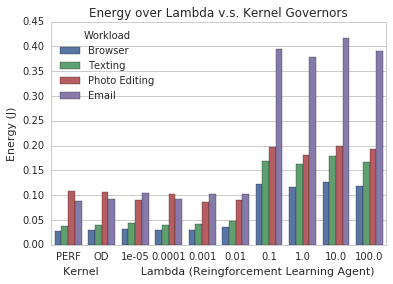

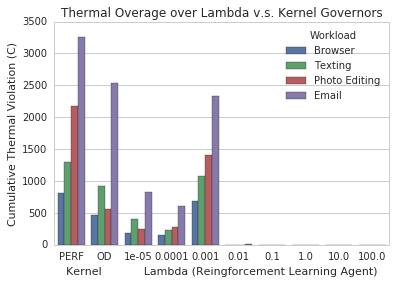

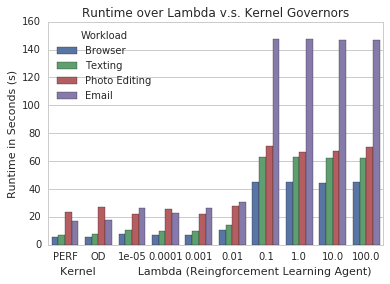

In [313]:
stats = ['energy', 'thermal_overage', 'runtime']
wrklds = ['Browser', 'Texting', 'Photo Editing', 'Email']
timing_data = ready_to_plot.sort_values(["lambda","workload","gov"], ascending=True)
for stat in stats:
    temp_dat = timing_data #.loc[timing_data.gov == 'RL']
#     r = temp_dat.loc[((temp_dat.threads==1) & (temp_dat.impl=='ST')), 'runtime'].values[0]
#     print(r)
#     temp_dat.runtime /= r
#     temp_dat = temp_dat.loc[(temp_dat.impl != 'ST'), ['threads','runtime','impl']]
    sns.barplot(x="impl", y=stat, hue="workload", hue_order=wrklds, data=temp_dat)
    title_str = " ".join(stat.title().split("_"))
    plt.title(title_str+" over Lambda v.s. Kernel Governors")
    plt.xlabel("Kernel            Lambda (Reingforcement Learning Agent)")
#     plt.yscale('log')
    if stat == 'runtime':
        plt.ylabel("Runtime in Seconds (s)")
    elif stat == 'energy':
        plt.ylabel("Energy (J)")
    elif stat == 'thermal_overage':
        plt.ylabel("Cumulative Thermal Violation (C)")
#     plt.ylabel("Runtime Normalized to ST")
    plt.legend(title="Workload", loc="best")
#     plt.axhline(y=r, color='r', linestyle='-')
    plt.savefig("{}.png".format(stat), bbox="tight")
    plt.show()

#### Plot Lambda = 0.0001 over time and compare to ondemand, performance on workload Email

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


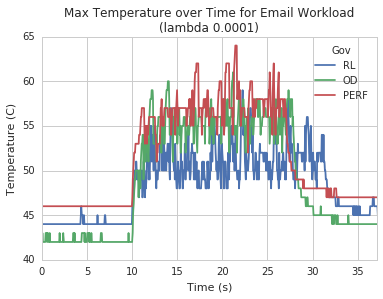

In [369]:
datas = []
# log = "mc1-1.log"
# log = "mc1-7.log"
workload = "Email"
fs = ["mc1-7.log","mc1-2_ondemand.log","mc1-7_performance.log"]
ls = [0.0001, -1, -2]
govs = ['RL', 'OD', 'PERF']
for log, lamb, gov in zip(fs, ls, govs):
    time_data = pd.read_csv(log, sep='\t', header=0, index_col=False)
    run = runtimes_df.loc[(runtimes_df['lambda'] == lamb) & (runtimes_df['workload'] == workload)]
    run.reset_index(drop=True, inplace=True)
    row = run.loc[0,:]
    start = row.start
    end = row.end
    time_period = time_data.loc[ (time_data.time >= (start-10)) & (time_data.time <= (end+10))]
    time_period['Maximum Temperature'] = time_period.apply(lambda r: np.max([r.temp4, r.temp5, r.temp6, r.temp7]), axis = 1)
    time_period['Gov'] = gov
    time_period.time -= np.min(time_period.time)
    datas.append(time_period)
# ready_to_plot['govabbr'] = ready_to_plot.apply(abbreviate, axis=1)
# ready_to_plot['impl'] = ready_to_plot.apply(lambda r: str(r['lambda']) if r['lambda'] > 0 else r.govabbr, axis=1)
time_periods = pd.concat(datas)


sns.tsplot(time_periods, time="time", value='Maximum Temperature', condition="Gov", unit="Gov")
plt.title("Max Temperature over Time for {} Workload\n(lambda {})".format(workload, ls[0]))
plt.xlabel("Time (s)")
plt.ylabel("Temperature (C)")
plt.savefig("Max_Temp_over_time_workload_{}_lambda_{}.png".format(workload,ls[0]), bbox="tight")
plt.show()

In [ ]:
sns.set_palette("hls")
impls = ['ST', 'MT', 'SYNCH', 'ASYNC']
thing = 'err_train'
for b in timed_conv_data_t.batch.unique():
    for thread_num in timed_conv_data_t.threads.unique():
        temp_dat = timed_conv_data_t.loc[((timed_conv_data_t.batch == b) & (timed_conv_data_t.threads==thread_num) )]
        temp_dat = temp_dat.loc[:, ['time',thing,'impl','impl_num']]
        temp_dat.sort_values(['impl_num','time'], ascending=True) 
        sns.tsplot(temp_dat, time="time", value=thing, condition="impl", unit="impl")
        plt.title("Error over Time for all Implementations\nwith Batch Size {} and {} Threads".format(b, thread_num))
        plt.xlabel("Time (s)")
        plt.ylabel("Error")
        plt.xlim(xmax=temp_dat.time.max())
        plt.savefig("{}_over_time_threads_{}_batch_{}.png".format("error",thread_num, b), bbox="tight")
        plt.show()